In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import dask.array as da
import time
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import math
import pywt
import scipy
from scipy import ndimage

# Import functions

# Clustering for DWT

In [3]:
def filter_out_nan(shaped):
    '''This function filters out nan values from a matrix nxm, and saves the index for threading back together'''
    data = []
    index = []
    index_nan = []
    count = 0
    for p in range(shaped.shape[0]):
        if np.isnan(shaped[p][0]):  #check if nan
            index_nan.append(count)
            count = count +1
        else:
            data.append(shaped[p])
            index.append(count)
            count = count + 1    
            
    data = da.stack(data, axis=0)
    return data, index, index_nan

In [4]:
def filter_in_nan(classes, index, index_nan):
    '''The inverse function of filter_out_nan - used to put nan values back into set after clustering'''
    classes_nan = np.ones(len(index_nan))*np.nan
    classes = np.append(classes, classes_nan)


    index_all = index + index_nan
    index_all = np.array(index_all)

    classes = classes[np.argsort(index_all)]
    
    return classes

# Index maps to return labels to initial data

In [5]:
#First, dwt_length is run to compute the length of each wavelet transform level.  This information is used to build the functions that will map the index up one level in the DWT (map_back_index)

In [6]:
#Record the lengths of the data at each wavelet transform.  This function is run outside map_back_classes
def dwt_length(data, wavelet):
    
    dwt_lengths = [data.size]
    max_level = pywt.dwt_max_level(data_len = data.size, filter_len = pywt.Wavelet(wave).dec_len)
    
    for i in range(max_level):
        l = pywt.dwt_coeff_len(dwt_lengths[i], pywt.Wavelet(wave).dec_len, mode='symmetric')
        dwt_lengths.append(l)
    
    return dwt_lengths

In [7]:
def middle_match(data_len,wavelet):
    
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len
    
    #Build the first row of the matrix
    I_m = np.zeros(data_len)
    I_m[:w_len] = w_fil
    
    #Make the shift matrix
    row_number = int(np.ceil((data_len-w_len)/2))
    if data_len%2 == 0:
        for j in range(1, row_number+1):
            row = np.zeros(data_len)
            row[2*j:w_len + 2*j]= w_fil
            I_m = np.concatenate((I_m,row), axis=0)
    
        I_m = np.reshape(I_m, (row_number+1,data_len))
    else:
        for j in range(1, row_number):
            row = np.zeros(data_len)
            row[2*j:w_len + 2*j]= w_fil
            I_m = np.concatenate((I_m,row), axis=0)
    
        I_m = np.reshape(I_m, (row_number,data_len))        
        
        
    return I_m

In [8]:
def top_match(data_len, wavelet):
    
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len
    
    #Build blank matrix
    row_number = int(np.ceil((w_len)/2))
    I_t = np.zeros((row_number-1,data_len))
    
    #Make the shift matrix
    for j in range(1,row_number):
        overflow = w_fil[:2*j]
        overflow = np.flip(overflow, axis=0)
        row_o = np.zeros(data_len)
        row_o[:2*j] = overflow
        
        leftover = w_fil[2*j:]
        row_l = np.zeros(data_len)
        row_l[:leftover.size] = leftover
        
        row = row_o + row_l      
        
        I_t[j-1] = row
    
    return I_t

In [9]:
def bot_match(data_len, wavelet):
   
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len

    row_number = int(np.ceil((w_len)/2))
    if data_len%2 ==0:
        I_b = np.zeros((row_number-1,data_len))
        for j in range(1,row_number):
            overflow = w_fil[-2*j:]
            overflow = np.flip(overflow, axis=0)
            row_o = np.zeros(data_len)
            row_o[-2*j:] = overflow
            
            
            leftover = w_fil[:-2*j]
            row_l = np.zeros(data_len)
            row_l[-leftover.size:] = leftover
            
            row = row_o + row_l
            
            I_b[j-1] = row         
    else:
        I_b = np.zeros((row_number,data_len))
        for j in range(1,row_number+1):         
            overflow = w_fil[-2*j+1:]
            overflow = np.flip(overflow, axis=0)
            row_o = np.zeros(data_len)
            row_o[-2*j+1:] = overflow
            
            leftover = w_fil[:-2*j+1]
            row_l = np.zeros(data_len)
            row_l[-leftover.size:] = leftover

            
            row = row_o + row_l
            
            I_b[j-1] = row
            
    return I_b

In [10]:
#Function used to build filter matrix for mapping classes back one level
def filter_matrix(data_len, wavelet):
    
    I_m = middle_match(data_len, wavelet)
    I_t = top_match(data_len, wavelet)
    I_b = bot_match(data_len, wavelet)
    
    I = np.concatenate((I_t,I_m), axis=0)
    I = np.concatenate((I,I_b), axis=0)
    
    return I

In [11]:
#Function used to discover classes at one stage higher resolution
def map_back_index(wavelet, dwt_lengths, max_level):
    
    index_up=[]
    
    for j in range(max_level):
        I = filter_matrix(dwt_lengths[j], wavelet)
        I = np.abs(I)
        classes_index = np.argmax(I,axis=0)
        index_up.append(classes_index)
        
    return index_up

# Having clustered, we now map each class back to initial data

In [12]:
def map_back_classes(data_classes, index_up, max_level):
    
    final_class = []
    for j in range(max_level):
        classt = data_classes[j]
        for i in range(j+1):
            classt = classt[index_up[j-i]][:,index_up[j-i]]
        final_class.append(classt)
        
    return final_class

# Clustering function

In [13]:
#Function to compute single level for feature data - adjusted to remove feature
def single_level_class(data_set, level, wavelet='haar', metric='euclidean', n_neighbors=3, eps_percentile=98, ratio_dwt=0.001):
    '''The following code computes one level of WaveScan'''
    
    startt=time.time()
    
    lvl = str(level)
    print("LEVEL: " + lvl)
    
    #Compute DWT
    start = time.time()
    wp = pywt.wavedecn(data=data_set, wavelet=wave, level = min(level,max_level))
    end = time.time()
    diff = str(end-start)
    print("DWT:" + diff)
    
    #Reshape the data for DBScan
    start = time.time()
    shaped = np.reshape(wp[0], (wp[0].shape[0], wp[0].shape[1]*wp[0].shape[2]))
    shaped = np.transpose(shaped)
    shaped.shape
    
    #Filter out the nan values for clustering
    data, index, index_nan = filter_out_nan(shaped)
    
    end = time.time()
    diff = str(end-start)
    print("Prep Data:" + diff)
    #Discover the epsilon for DBScan using knn. 
    start = time.time()
    
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)

    #Set the distance to use as within eps_percentile:
    epsilon = np.percentile(distances[:,[1,-1]], eps_percentile)
    if epsilon ==0:
        epsilon = 1
    print(epsilon)
    
    #Choose the min cluster size.  This is done by setting a percent of the size of the DWT coefficents (as long as it is
    # at least 2).
    min_size = max(np.ceil(data.shape[0]*ratio_dwt), 2)
    end = time.time()
    diff = str(end-start)
    print("Find Params:" + diff)
    
    #Perform db scan and return the result
    start = time.time()
    classes = DBSCAN(eps=epsilon, min_samples=min_size, metric=metric).fit_predict(data)
    end = time.time()
    diff = str(end-start)
    print("DBSCAN:" + diff)
    
    #Filter back in the nan values before reshaping:
    start = time.time()
    classes = filter_in_nan(classes, index, index_nan)
    
    #Reshape classes to match back up with original
    classes = np.reshape(classes, (wp[0].shape[1], wp[0].shape[2]))
    
    end = time.time()
    diff = str(end-start)
    print("Find Classes:" + diff)
    
    
    endt = time.time()
    difft = str(endt - startt)
    print("TOTAL: " + difft)
    print("")
    
    return classes

# Make Examples

In [14]:
test1 = np.kron([[1, 0] * 1, [0, 1] * 1] * 1, np.ones((128,128)))

In [15]:
test1.shape

(256, 256)

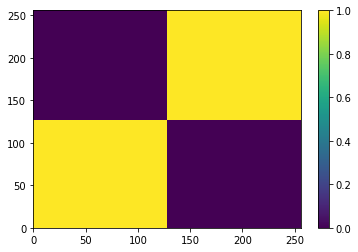

In [16]:
p = plt.pcolormesh(test1)
plt.colorbar(p)

In [17]:
test1 = np.tile(test1,(256,1,1))

In [18]:
test2 = np.kron([[1, 0] * 2, [0, 1] * 2] * 2, np.ones((64, 64)))

In [19]:
test2.shape

(256, 256)

In [20]:
test2 = np.tile(test2,(256,1,1))

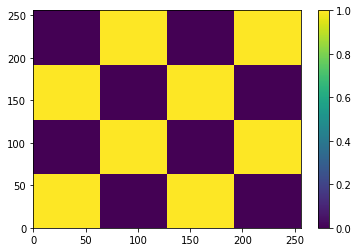

In [21]:
p = plt.pcolormesh(test2[200])
plt.colorbar(p)

In [22]:
noise = np.random.normal(0,.01,(256,256,256))

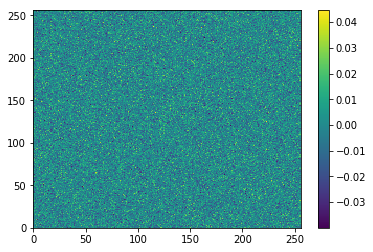

In [23]:
p = plt.pcolormesh(noise[34])
plt.colorbar(p)

In [24]:
test = test1+2*test2+ noise

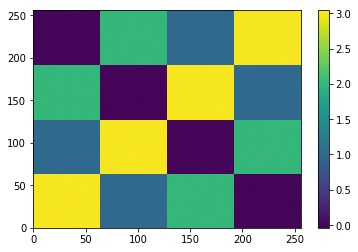

In [25]:
p = plt.pcolormesh(test[0])
plt.colorbar(p)

In [26]:
b = np.linspace(0, 21.3*np.pi, num=256)
b = np.sin(b)
b = np.array([[b]])
b = np.transpose(b)
b.shape

(256, 1, 1)

In [27]:
c = np.tile(b, (1,256,256))
c.shape

(256, 256, 256)

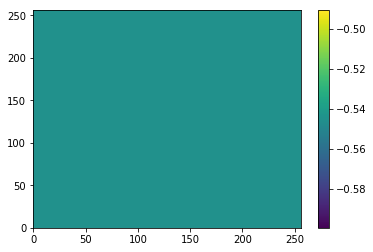

In [28]:
p = plt.pcolormesh(c[86])
plt.colorbar(p)

In [29]:
final = test+c

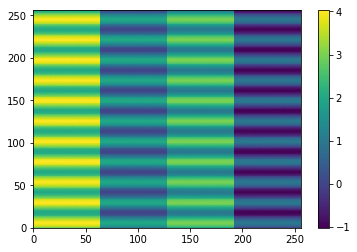

In [30]:
p = plt.pcolormesh(final[:,:,3])
plt.colorbar(p)

In [34]:
w = pywt.wavedecn(final, ('haar','haar'), level=2)

AttributeError: 'tuple' object has no attribute 'lower'

In [83]:
a = np.ones((8,4))
a

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [88]:
b = pywt.wavedecn(a,'haar',axes=[0], level=2)
b

[array([[2., 2., 2., 2.],
        [2., 2., 2., 2.]]), {'d': array([[0., 0., 0., 0.],
         [0., 0., 0., 0.]])}, {'d': array([[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]])}]

In [89]:
b[0].shape

(2, 4)

In [93]:
c = pywt.wavedecn(b[0],'haar', axes=[1], level=2)
c

[array([[4.],
        [4.]]), {'d': array([[0.],
         [0.]])}, {'d': array([[0., 0.],
         [0., 0.]])}]

In [92]:
d = pywt.wavedecn(a,'haar', level=2)
d

[array([[4.],
        [4.]]), {'ad': array([[0.],
         [0.]]), 'da': array([[0.],
         [0.]]), 'dd': array([[0.],
         [0.]])}, {'ad': array([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]), 'da': array([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]), 'dd': array([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]])}]

# Try to seperate layers

In [85]:
#Set the number of levels for DWT, as well as the wavelet
min_len = min(test.shape)
wave = 'haar'

#figure out max possible levels to loop over given size of data
max_level = pywt.dwt_max_level(data_len = min_len, filter_len = pywt.Wavelet(wave).dec_len) 
max_level

8

In [86]:
#dwt_lengths need to be computed for both lat and lon.
dwt_lengths = dwt_length(test[0][0], wave)
dwt_lengths

[256, 128, 64, 32, 16, 8, 4, 2, 1]

In [87]:
index_up = map_back_index(wave,dwt_lengths,max_level)

In [88]:
class_sets = []
for i in range(1,max_level+1):
    classes = single_level_class(final, level = i, n_neighbors = 4)
    class_sets.append(classes)

LEVEL: 1
DWT:1.4454383850097656
Prep Data:2.6066019535064697
0.1417604529934865
Find Params:34.703535079956055
DBSCAN:37.76843571662903
Find Classes:0.0018489360809326172
TOTAL: 76.52716326713562

LEVEL: 2
DWT:1.4974942207336426
Prep Data:0.6465489864349365
0.098792360413904
Find Params:5.661675453186035
DBSCAN:3.6465256214141846
Find Classes:0.000993490219116211
TOTAL: 11.453677415847778

LEVEL: 3
DWT:1.5243988037109375
Prep Data:0.15358495712280273
0.0684589295478454
Find Params:1.26336669921875
DBSCAN:0.6274573802947998
Find Classes:0.00017595291137695312
TOTAL: 3.5693306922912598

LEVEL: 4
DWT:1.508575439453125
Prep Data:0.03831934928894043
0.0499755761338485
Find Params:0.301708459854126
DBSCAN:0.14442181587219238
Find Classes:9.822845458984375e-05
TOTAL: 1.993976354598999

LEVEL: 5
DWT:1.518083095550537
Prep Data:0.009650230407714844
0.03955311280445646
Find Params:0.08047008514404297
DBSCAN:0.039136648178100586
Find Classes:7.224082946777344e-05
TOTAL: 1.6477088928222656

LEVEL:

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 1, n_neighbors = 4

In [89]:
class_sets = map_back_classes(class_sets, index_up, 7)

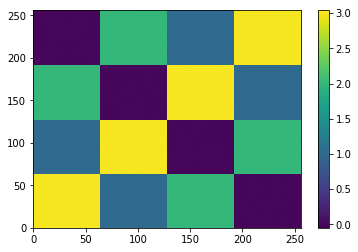

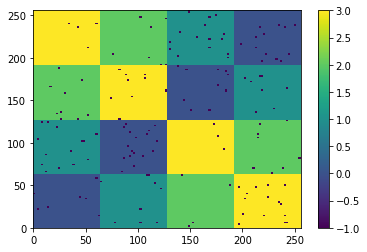

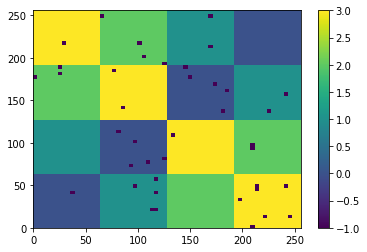

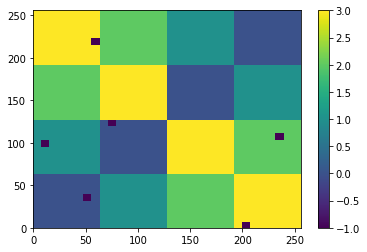

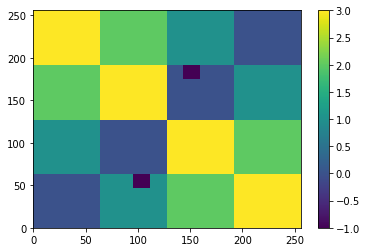

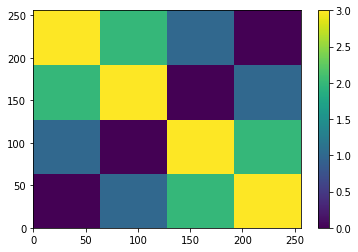

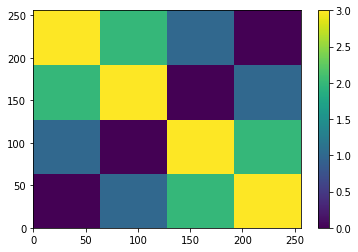

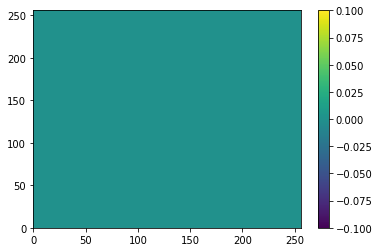

In [90]:
plt.figure(-1)
p = plt.pcolormesh(test[0])
plt.colorbar(p)

for i in range(0,7):
    plt.figure(i)
    p = plt.pcolormesh(class_sets[i])
    plt.colorbar(p)

# Make Examples

In [202]:
test1 = np.kron([[1, 0] * 1, [0, 1] * 1] * 1, np.ones((2, 128,128)))

In [203]:
test1.shape

(2, 256, 256)

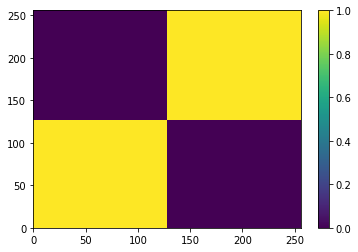

In [204]:
p = plt.pcolormesh(test1[0])
plt.colorbar(p)

In [205]:
test2 = np.kron([[1, 0] * 2, [0, 1] * 2] * 2, np.ones((256, 64, 64)))

In [206]:
test2.shape

(256, 256, 256)

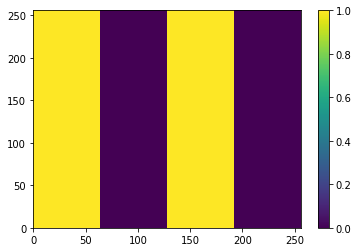

In [219]:
p = plt.pcolormesh(test2[:,:,])
plt.colorbar(p)

In [192]:
a = np.ones((256,256,1))

In [193]:
b = np.linspace(0, 21.3*np.pi, num=256)
b = np.sin(b)
b = np.array([[b]])
b.shape

(1, 1, 256)

In [194]:
c = np.kron(a,b)

In [195]:
c.shape

(256, 256, 256)

In [196]:
c[1,0,0]

0.0

In [208]:
test3 = test2+c

In [210]:
np.max(test3)

1.999993169831719

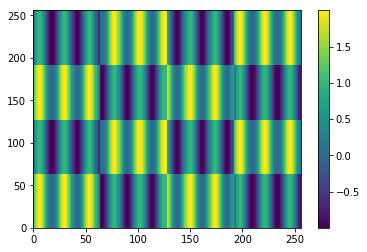

In [216]:
p = plt.pcolormesh(test3[0,:,:])
plt.colorbar(p)

In [38]:
test4 = np.random.normal(0,.01,(256,256,256))

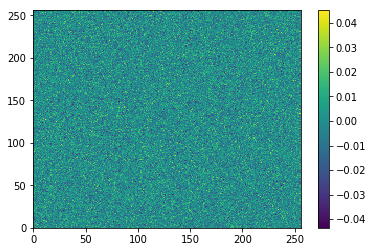

In [39]:
p = plt.pcolormesh(test4[34])
plt.colorbar(p)

In [86]:
test = test1+2*test2+ test4

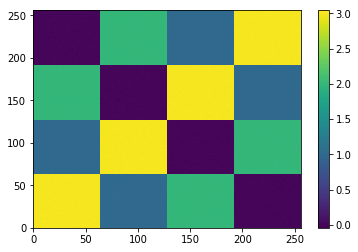

In [87]:
p = plt.pcolormesh(test[34])
plt.colorbar(p)